In [1]:
import sys
sys.path.append("../")
sys.path.append("../../")

In [2]:
import numpy as np
from Onsager_calc_db import *
import onsager.crystal as crystal
from states import *
from stars import *
from vector_stars import *
from representations import *
import time
import pickle
import h5py
from scipy.constants import physical_constants
from scipy.optimize import least_squares
kB = physical_constants['Boltzmann constant in eV/K'][0]
from matplotlib import pyplot as plt
import scipy.stats as spstats
from collections import defaultdict

/usr/local/lib/python3.6/dist-packages/onsager-1.3.3-py3.6.egg/onsager/cluster.py:835: NumbaDeprecationWarning: The 'numba.jitclass' decorator has moved to 'numba.experimental.jitclass' to better reflect the experimental nature of the functionality. Please update your imports to accommodate this change and see http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#change-of-jitclass-location for the time frame.


In [3]:
%%time
# Let's load the pickle file we just saved
with open("FeCr_Onsg.pkl","rb") as fl:
    onsagercalculator = pickle.load(fl)

CPU times: user 8min 10s, sys: 5.44 s, total: 8min 16s
Wall time: 8min 23s


In [4]:
# Now, we'll look at the complex states in our thermodynamic shell
# For each state, the first number printed out is the index assgined to the symmetry-unique group the state
# belongs to,
# The second line is a (basis index, orientation) tuple that tells us where in a unit cell the pure dumbbell
# is and with what orientation.
# The third line prints the distance of the position of the dumbbell from the solute.
# Note that the first complex state is an origin state (pure dumbbell on top of solute) and is unphysical.
# We'll then match our complex states, with the states shown in Messina et. al. (1nnA, 1nnB etc)
count = 0
for star in onsagercalculator.thermo.stars[:onsagercalculator.thermo.mixedstartindex]:
    print(count)
    db = star[0].db
    print(onsagercalculator.pdbcontainer.iorlist[db.iorind])
    print(np.dot(onsagercalculator.crys.lattice, db.R))
    print()
    count += 1

0
(0, array([ 0.17819091, -0.17819091,  0.        ]))
[0. 0. 0.]

1
(0, array([-1.78190909e-01, -1.01947883e-17,  1.78190909e-01]))
[-0.14155 -0.14155 -0.14155]

2
(0, array([-1.78190909e-01, -1.01947883e-17,  1.78190909e-01]))
[ 0.14155 -0.14155 -0.14155]

3
(0, array([ 0.17819091, -0.17819091,  0.        ]))
[0.     0.     0.2831]

4
(0, array([ 0.17819091, -0.17819091,  0.        ]))
[0.2831 0.     0.    ]

5
(0, array([ 0.17819091, -0.17819091,  0.        ]))
[ 0.     -0.2831  0.2831]

6
(0, array([ 1.78190909e-01,  1.78190909e-01, -1.01947883e-17]))
[-0.2831 -0.2831  0.    ]

7
(0, array([ 0.17819091, -0.17819091,  0.        ]))
[0.2831 0.2831 0.    ]

8
(0, array([0.17819091, 0.        , 0.17819091]))
[0.42465 0.14155 0.14155]

9
(0, array([ 0.        ,  0.17819091, -0.17819091]))
[-0.42465 -0.14155 -0.14155]

10
(0, array([-1.78190909e-01, -1.01947883e-17,  1.78190909e-01]))
[-0.14155  0.14155 -0.42465]

11
(0, array([ 0.17819091, -0.17819091,  0.        ]))
[-0.14155  0.14155  

In [5]:
# Next, we assign labels to the states we have just identified
# No interaction will be assumed when a corresponding energy is not found in Messina et. al.'s database.
name_to_themo_star = {"1nnA":1, "1nnB":2, "2nnA":3, "2nnB":4, "3nnB":5,"3nnC":6,
       "4nnA":9,"4nnB":11,"4nnC":8, "5nnB":13}

In [6]:
# sorting out the jumps with the nomenclatures
jmpdict = {"1nnA_2nnA":[], "1nnA_2nnB":[], "1nnA_3nnB":[], "1nnA_3nnC":[], "1nnB_2nnB":[], "1nnB_3nnB":[],
          "1nnB_5nnB":[], "2nnA_4nnC":[], "2nnB_4nnB":[], "2nnB_4nnC":[]}
# Now identify the jumps and put them into the dictionaries
for jlistind, jlist in enumerate(onsagercalculator.jnet1):
    jmp = jlist[0]
    state1 = jmp.state1
    state2 = jmp.state2
    
    star1 = onsagercalculator.kinetic.complexIndexdict[state1][1]
    star2 = onsagercalculator.kinetic.complexIndexdict[state2][1]
    
    if star1 in onsagercalculator.thermo2kin and star2 in onsagercalculator.thermo2kin:
        thermo_star1 = onsagercalculator.thermo.complexIndexdict[state1][1]
        thermo_star2 = onsagercalculator.thermo.complexIndexdict[state2][1]
        name1 = ""
        name2 = ""
        #Now see which categories the states belong to
        star1found = False
        count1 = 0
        star2found = False
        count2 = 0
        for (key, value) in name_to_themo_star.items():
            if thermo_star1==value:
                star1found = True
                count1 += 1
                name1 = key
            if thermo_star2==value:
                star2found = True
                count2 += 1
                name2 = key
        # just to ensure we don't have any multiple counting business going on.
        if count1>1:
            print(thermo_star1)
        if count2>1:
            print(thermo_star2)
        # Now concatenate names
        jname = name1+"_"+name2
        jnamerev = name2+"_"+name1
        try:
            jmpdict[jname].append(jlistind)
        except:
            try:
                # maybe the jump we have is the reverse of what we stored as the label in the dictionary?
                jmpdict[jnamerev].append(jlistind)
            except:    
                continue

# check to see we have found all the jumps
jmpdict               

{'1nnA_2nnA': [5],
 '1nnA_2nnB': [6],
 '1nnA_3nnB': [4],
 '1nnA_3nnC': [7],
 '1nnB_2nnB': [1],
 '1nnB_3nnB': [3],
 '1nnB_5nnB': [2],
 '2nnA_4nnC': [9],
 '2nnB_4nnB': [8],
 '2nnB_4nnC': [10]}

In [7]:
E_f_pdb = 4.0799084 # formation energy of pure dumbbell - from energy file
# Now, we assign energies to the complex states in the thermo shell
# name to supercell energy
name_to_en = {"1nnA":-2081.86385487, "1nnB":-2081.96714335, 
                      "2nnA":-2081.84673179, "2nnB":-2081.84805032, 
                      "3nnB":-2081.89911432,"3nnC":-2081.89517078,
                      "4nnA":-2081.89240119,"4nnB":-2081.88260599,
                      "4nnC":-2081.90014080,"5nnB":-2081.89623144}

In [8]:
E_sup_pdb = -2080.58061654
E_sup_solute = -2077.70333299
E_bulk = -2076.35510458 # E_bulk is the same as E_ref
name_to_Ef = defaultdict(float)
for (key, E_IB) in name_to_en.items():
    # get the binding energy first
    Eb = -E_IB + E_sup_pdb + E_sup_solute - E_bulk
    # Next, get the formation energy (relative to solute formation energy)
    name_to_Ef[key] = E_f_pdb - Eb
name_to_Ef["4nnD"] = E_f_pdb

In [9]:
# The complex energies are set. Now, we set the mixed dumbbell energies
E_b_mdb = 2081.97387181 + E_sup_pdb + E_sup_solute - E_bulk
E_f_mdb = E_f_pdb - E_b_mdb

# Check the mixed dumbbell binding energy
print(E_f_mdb - E_f_pdb)

-0.04502686000023459


In [10]:
Jname_2_TS_en = {"1nnA_2nnA":-2081.53754083, "1nnA_2nnB":-2081.45300295, "1nnA_3nnB":-2081.54309435,
                 "1nnA_3nnC":-2081.51203629, "1nnB_2nnB":-2081.59390973, "1nnB_3nnB":-2081.58124941,
                 "1nnB_5nnB":-2081.56664001, "2nnA_4nnC":-2081.53814922, "2nnB_4nnB":-2081.53362146,
                 "2nnB_4nnC":-2081.53385038}

In [11]:
# Now, we have to find the TS energies.
Jname_2_ef_ts = defaultdict(float)
for (key, E_IB) in Jname_2_TS_en.items():
    Eb = -E_IB + E_sup_pdb + E_sup_solute - E_bulk
    # Next, get the formation energy (relative to solute formation energy)
    Jname_2_ef_ts[key] = E_f_pdb - Eb

In [12]:
Jname_2_ef_ts

defaultdict(float,
            {'1nnA_2nnA': 4.471212519999859,
             '1nnA_2nnB': 4.5557503999998294,
             '1nnA_3nnB': 4.465658999999937,
             '1nnA_3nnC': 4.496717059999788,
             '1nnB_2nnB': 4.4148436199998065,
             '1nnB_3nnB': 4.427503939999929,
             '1nnB_5nnB': 4.442113340000083,
             '2nnA_4nnC': 4.470604130000061,
             '2nnB_4nnB': 4.475131889999807,
             '2nnB_4nnC': 4.474902970000108})

In [13]:
Jname_2_mig = defaultdict(float)
for (key, TS_en) in Jname_2_ef_ts.items():
    initstar = key[:4]
    Jname_2_mig[key] = TS_en - name_to_Ef[initstar]

In [14]:
# Check that correct energies have been assigned to the jumps
Jname_2_mig

defaultdict(float,
            {'1nnA_2nnA': 0.3263140399999429,
             '1nnA_2nnB': 0.41085191999991366,
             '1nnA_3nnB': 0.32076052000002164,
             '1nnA_3nnC': 0.35181857999987187,
             '1nnB_2nnB': 0.3732336199996098,
             '1nnB_3nnB': 0.38589393999973254,
             '1nnB_5nnB': 0.4005033399998865,
             '2nnA_4nnC': 0.30858256999999867,
             '2nnB_4nnB': 0.31442885999967984,
             '2nnB_4nnC': 0.3141999399999804})

In [15]:
E_IB_43, E_IB_2 = -2081.60898764, -2081.73238117
Eb_43, Eb_2 = -E_IB_43 + E_sup_pdb + E_sup_solute - E_bulk, -E_IB_2 + E_sup_pdb + E_sup_solute - E_bulk 
# Next, get the formation energy (relative to solute formation energy)
ef_ts_43 = E_f_pdb - Eb_43
ef_ts_2 = E_f_pdb - Eb_2
print(ef_ts_2-E_f_mdb, ef_ts_43 - E_f_mdb, ef_ts_43 - name_to_Ef["1nnB"])

0.2414906400003929 0.36488417000009576 0.3581557099996644


In [16]:
# get the SCMF PDC data from the file to compare to
temp = []
dat = []
with open("PDC_ratio_Cr.dat", "r") as fl:
    for line in fl:
        arr = line.split()
        temp.append(float(arr[0]))
        dat.append(float(arr[1]))
temp = np.array(temp)
dat = np.array(dat)

## Cr calculations

In [18]:
# Jump rates and energy barriers set. Now, let's set the calculations up.
vu0=4.4447
vu2=4.5551
Dconv=1.

predb0, enedb0 = np.ones(1), np.array([E_f_pdb])

# We'll measure every formation energy relative to the solute formation energy.
preS, eneS = np.ones(1), np.array([0.0])

# Next, interaction or the excess energies and pre-factors for solutes and dumbbells.
preSdb, eneSdb = np.ones(onsagercalculator.thermo.mixedstartindex), \
                 np.zeros(onsagercalculator.thermo.mixedstartindex)
# Now, we go over the necessary stars and assign interaction energies
for (key, index) in name_to_themo_star.items():
    eneSdb[index] = name_to_Ef[key] - E_f_pdb

predb2, enedb2 = np.ones(1), np.array([E_f_mdb])

# Transition state energies - For omega0, omega2 and omega43, the first type is the Johnson jump,
# and the second one is the Rigid jump.

# Omega0 TS eneriges
preT0, eneT0 = Dconv*vu0*np.ones(1), np.array([E_f_pdb + 0.33759025])

# Omega2 TS energies
Nj2 = len(onsagercalculator.jnet2)
preT2, eneT2 = Dconv*vu2*np.ones(Nj2), np.array([ef_ts_2])

# Omega43 TS energies
preT43, eneT43 = Dconv*vu0*np.ones(1), np.array([ef_ts_43])

# Omega1 TS energies - need to be careful here
preT1 = Dconv*vu0*np.ones(len(onsagercalculator.jnet1))
eneT1 = np.array([eneT0[i] for i in onsagercalculator.om1types])
# Now, we go over the jumps that are provided and make the necessary changes
for (key, index) in jmpdict.items():
    eneT1[index] = Jname_2_ef_ts[key]
    
# set origin state jumps to zeros - the code handles this anyway
eneT1[0] = 0.0

In [19]:
# Then we calculate the transport coefficients
from tqdm import tqdm

diff_aa_Cr = np.zeros(len(temp))
diff_ab_Cr = np.zeros(len(temp))
diff_bb = np.zeros(len(temp))
diff_bb_non_loc = np.zeros(len(temp))

start = time.time()
for i in tqdm(range(len(temp)), position=0, leave=True):
    T = temp[i]
    kT = kB*T
    bFdb0, bFdb2, bFS, bFSdb, bFT0, bFT1, bFT2, bFT3, bFT4 = \
        onsagercalculator.preene2betafree(kT, predb0, enedb0, preS, eneS, preSdb, eneSdb, predb2, enedb2,
                                               preT0, eneT0, preT2, eneT2, preT1, eneT1, preT43, eneT43)

    # get the probabilities and other data from L_ij
    L0bb, (L_uc_aa,L_c_aa), (L_uc_bb,L_c_bb), (L_uc_ab,L_c_ab)=\
    onsagercalculator.L_ij(bFdb0, bFT0, bFdb2, bFT2, bFS, bFSdb, bFT1, bFT3, bFT4)
    
    L_aa = L_uc_aa + L_c_aa
    L_bb = L_uc_bb + L_c_bb
    L_ab = L_uc_ab + L_c_ab
    
    diff_aa_Cr[i] = L_aa[0][0]
    diff_ab_Cr[i] = L_ab[0][0]
    diff_bb[i] = L_bb[0][0]
    diff_bb_non_loc[i] = L0bb[0][0]
        
print(time.time() - start)

100%|██████████| 381/381 [24:49<00:00,  3.91s/it]

1489.8232924938202


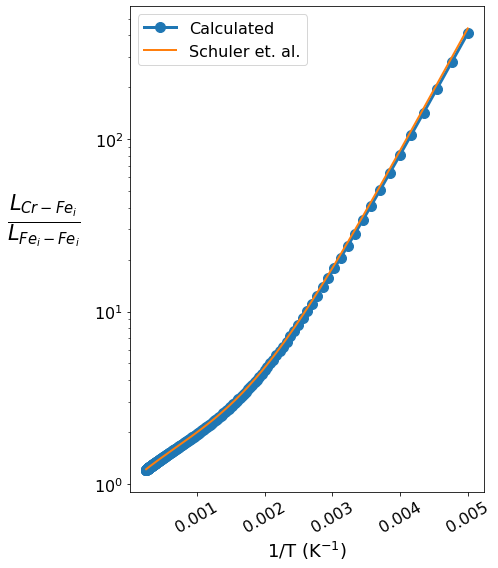

In [29]:
T_arr = temp
plt.figure(figsize=(7,8))
plt.semilogy(1/T_arr, diff_ab_Cr/(diff_bb_non_loc), marker="o",
             label="Calculated", linewidth=3, ms=10)
plt.semilogy(1/temp, np.array(dat), linewidth=2,
             label="Schuler et. al.")
plt.xlabel(r"1/T (K$^{-1}$)", fontsize=18)
plt.ylabel(r"$\frac{L_{Cr-Fe_i}}{L_{Fe_i-Fe_i}}$", fontsize=30, rotation = 0, labelpad=50)
# plt.legend(loc="best", fontsize=16)
# plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=16, rotation = 30)
plt.yticks(fontsize=16)
# plt.xlim(400, 1301)
plt.tight_layout()
plt.legend(fontsize=16)
# plt.savefig("pdc_ratio_Cr_Fe_log.png")

In [30]:
# Now save all the arrays as files
with h5py.File("Cr_data.h5","w") as fl:
    fl.create_dataset("diff_aa", data=diff_aa_Cr)
    fl.create_dataset("diff_ab", data=diff_ab_Cr)
    fl.create_dataset("diff_bb_nl", data=diff_bb_non_loc)
    fl.create_dataset("diff_bb", data=diff_bb)
    fl.create_dataset("Temp", data=np.array(temp))

In [19]:
# Now let's do the infinite temeperature limit
kT = np.inf
bFdb0, bFdb2, bFS, bFSdb, bFT0, bFT1, bFT2, bFT3, bFT4 = \
    onsagercalculator.preene2betafree(kT, predb0, enedb0, preS, eneS, preSdb, eneSdb, predb2, enedb2,
                                           preT0, eneT0, preT2, eneT2, preT1, eneT1, preT43, eneT43)
#     bFdicts[i] = [bFdb0, bFdb2, bFS, bFSdb, bFT0, bFT1, bFT2, bFT3, bFT4]
# get the probabilities and other data from L_ij
L0bb, (L_uc_aa,L_c_aa), (L_uc_bb,L_c_bb), (L_uc_ab,L_c_ab)=\
onsagercalculator.L_ij(bFdb0, bFT0, bFdb2, bFT2, bFS, bFSdb, bFT1, bFT3, bFT4)

L_aa = L_uc_aa + L_c_aa
L_bb = L_uc_bb + L_c_bb
L_ab = L_uc_ab + L_c_ab

In [21]:
L_ab[0][0]/L_aa[0][0]

2.417137005810162